# Homework assignment #2

## Section 1
### Mock setup: daily control flow

This section implements a mock version of the daily processing pipeline.
No real data is downloaded at this stage.

In [1]:
from datetime import date, timedelta
from pathlib import Path
import json
import shutil

# ======================================================
# SETTINGS (replacement for command-line arguments)
# ======================================================

# Full date range that should be processed
START_DATE = date(2024, 12, 1)
END_DATE   = date(2024, 12, 5)

# If None  -> behave like "no arguments":
#              process from the oldest missing day to END_DATE
# If date  -> process only this specific day
RUN_DATE = None

# Mock mode:
MOCK = True

# Days that should fail during mock processing
# (used to test error handling and recovery)
MOCK_FAIL_DAYS = set() 

# ======================================================
# PATH SETUP
# ======================================================

# Base directory of the project
BASE = Path(".").resolve()

# Directory structure used by the pipeline
PATHS = {
    "raw": BASE / "data" / "raw",
    "archive": BASE / "data" / "archive",
    "done": BASE / "data" / "state" / "done",
    "failed": BASE / "data" / "state" / "failed",
}

# Create directories if they do not exist
for p in PATHS.values():
    p.mkdir(parents=True, exist_ok=True)

# ======================================================
# HELPER FUNCTIONS
# ======================================================

def daterange(start, end):
    """
    Generate a list of all dates between start and end (inclusive).
    """
    cur = start
    out = []
    while cur <= end:
        out.append(cur)
        cur += timedelta(days=1)
    return out


def done_marker(day):
    """
    Path to the 'done' marker file for a given day.
    The existence of this file means the day was successfully processed.
    """
    return PATHS["done"] / f"{day.isoformat()}.json"


def failed_marker(day):
    """
    Path to the 'failed' marker file for a given day.
    """
    return PATHS["failed"] / f"{day.isoformat()}.json"


def pick_target_days(all_days, run_date):
    """
    Determine which days should be processed in the current run.

    - If run_date is provided:
        process only this single day.
    - Otherwise:
        find the oldest missing day and process all days from there onward.
    """
    if run_date is not None:
        return [run_date]

    missing = [d for d in all_days if not done_marker(d).exists()]
    if not missing:
        return []

    oldest_missing = missing[0]
    return [d for d in all_days if d >= oldest_missing]

# ======================================================
# MOCK PIPELINE IMPLEMENTATION
# ======================================================

def mock_download(day):
    """
    Simulate a daily data download by creating a small text file.
    """
    path = PATHS["raw"] / f"daily_{day.isoformat()}.txt"
    path.write_text(f"fake data for {day}\n", encoding="utf-8")
    return path


def process_one_day(day):
    """
    Process a single day.

    In mock mode:
    - simulate data download,
    - optionally trigger a failure,
    - archive the mock input file.

    In real mode:
    - the download step is handled separately,
    - no mock archiving is performed here.
    """
    print(f"Processing {day}")

    if MOCK:
        # 1) Download (mock)
        raw_path = mock_download(day)

        # 2) Simulate a processing failure if requested
        if day.isoformat() in MOCK_FAIL_DAYS:
            raise RuntimeError("Simulated processing failure")

        # 3) Archive raw mock data after successful processing
        archive_path = PATHS["archive"] / raw_path.name
        shutil.move(str(raw_path), str(archive_path))

    else:
        # Real data download and processing are handled outside mock mode
        pass


def run_pipeline():
    """
    Main control-flow function.
    Executes the daily pipeline according to the configured settings.
    """
    all_days = daterange(START_DATE, END_DATE)
    target_days = pick_target_days(all_days, RUN_DATE)

    if not target_days:
        print("No days to process.")
        return

    for day in target_days:
        try:
            process_one_day(day)
            done_marker(day).write_text(
                json.dumps(
                    {"date": day.isoformat(), "status": "done"},
                    indent=2,
                ),
                encoding="utf-8",
            )
            print(f"OK  {day}")
        except Exception as e:
            failed_marker(day).write_text(
                json.dumps(
                    {"date": day.isoformat(), "status": "failed", "error": str(e)},
                    indent=2,
                ),
                encoding="utf-8",
            )
            print(f"FAIL {day} :: {e}")


### Test 1: Run without arguments

In [2]:
RUN_DATE = None
MOCK = True
MOCK_FAIL_DAYS = set()

run_pipeline()


No days to process.


### Test 2: Simulated failure and recovery

In [3]:
# Remove one done marker to simulate a missing day
marker = PATHS["done"] / "2024-12-02.json"
if marker.exists():
    marker.unlink()

RUN_DATE = None
MOCK = True
MOCK_FAIL_DAYS = {"2024-12-02"}

run_pipeline()


Processing 2024-12-02
FAIL 2024-12-02 :: Simulated processing failure
Processing 2024-12-03
OK  2024-12-03
Processing 2024-12-04
OK  2024-12-04
Processing 2024-12-05
OK  2024-12-05


### Test 3: Recovery after failure


In [4]:
RUN_DATE = None
MOCK = True
MOCK_FAIL_DAYS = set()

run_pipeline()


Processing 2024-12-02
OK  2024-12-02
Processing 2024-12-03
OK  2024-12-03
Processing 2024-12-04
OK  2024-12-04
Processing 2024-12-05
OK  2024-12-05


### Test 4: Processing a single day

In [5]:
# Remove marker to force re-processing
marker = PATHS["done"] / "2024-12-04.json"
if marker.exists():
    marker.unlink()

RUN_DATE = date(2024, 12, 4)
MOCK = True
MOCK_FAIL_DAYS = set()

run_pipeline()

Processing 2024-12-04
OK  2024-12-04


## Section 2
### ERA5 download

In this section we replace the mock download step with a real ERA5 download via the Copernicus Climate Data Store (CDS) API.
The download routine is configured via a dictionary and does not hardcode user settings inside the function.

In [6]:
from pathlib import Path
import cdsapi

# ======================================================
# ERA5 DOWNLOAD CONFIGURATION
# ======================================================

# Configuration dictionary for ERA5 pressure-level downloads.
# All dataset-specific settings are defined here to keep the
# download routine itself flexible and reusable.
ERA5_CFG = {
    "dataset": "reanalysis-era5-pressure-levels",
    "product_type": "reanalysis",

    # Humidity variable to be downloaded
    # (can be changed without modifying the download function)
    "variable": "relative_humidity",
    # Alternative: "specific_humidity"

    # Pressure levels in hPa
    "pressure_levels": [975, 900, 800, 500, 300],

    # 6-hourly time steps
    "times": ["00:00", "06:00", "12:00", "18:00"],

    # Output format
    "format": "netcdf",
}

# ======================================================
# ERA5 DOWNLOAD FUNCTION
# ======================================================

def era5_download(day, cfg, out_dir: Path) -> Path:
    """
    Download ERA5 pressure-level data for a single day.

    The function retrieves data for all configured pressure levels
    and time steps and stores the result as a single daily file.

    Notes:
    - No user settings are hardcoded in this function.
    - All configuration is passed via the cfg dictionary.
    - Returns the path to the downloaded file.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    out_path = out_dir / f"era5_{cfg['variable']}_{day.isoformat()}.nc"

    request = {
        "product_type": cfg["product_type"],
        "variable": cfg["variable"],
        "pressure_level": [str(pl) for pl in cfg["pressure_levels"]],
        "year": f"{day:%Y}",
        "month": f"{day:%m}",
        "day": f"{day:%d}",
        "time": cfg["times"],
        "format": cfg["format"],
    }

    client = cdsapi.Client()
    client.retrieve(cfg["dataset"], request, str(out_path))

    return out_path


In [7]:
# ======================================================
# TEST: REAL ERA5 DOWNLOAD FOR A SINGLE DAY
# ======================================================

# Disable mock mode to perform a real data download
MOCK = False

RUN_DATE = date(2024, 12, 1)
MOCK_FAIL_DAYS = set()

# Run the daily processing pipeline
run_pipeline()

# ======================================================
# CHECK RESULT
# ======================================================

# Verify that the downloaded file was archived correctly
p = PATHS["archive"] / f"era5_{ERA5_CFG['variable']}_2024-12-01.nc"
print("Archived file exists:", p.exists())

if p.exists():
    print("File size (MB):", round(p.stat().st_size / (1024**2), 2))
    # print("Path:", p)

Processing 2024-12-01
OK  2024-12-01
Archived file exists: True
File size (MB): 36.24


In [8]:
import xarray as xr

p = PATHS["archive"] / f"era5_{ERA5_CFG['variable']}_2024-12-01.nc"
ds = xr.open_dataset(p, engine="h5netcdf")
ds

<xarray.Dataset> Size: 83MB
Dimensions:         (valid_time: 4, pressure_level: 5, latitude: 721,
                     longitude: 1440)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 32B 2024-12-01 ... 2024-12-01...
  * pressure_level  (pressure_level) float64 40B 975.0 900.0 800.0 500.0 300.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    number          int64 8B ...
    expver          (valid_time) <U4 64B ...
Data variables:
    r               (valid_time, pressure_level, latitude, longitude) float32 83MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-20T20:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
candidates = [ERA5_CFG["variable"], "r", "q"]
var_name = next((v for v in candidates if v in ds.data_vars), list(ds.data_vars)[0])

print("Using variable:", var_name)
da = ds[var_name]
da


Using variable: r


<xarray.DataArray 'r' (valid_time: 4, pressure_level: 5, latitude: 721,
                       longitude: 1440)> Size: 83MB
[20764800 values with dtype=float32]
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 32B 2024-12-01 ... 2024-12-01...
  * pressure_level  (pressure_level) float64 40B 975.0 900.0 800.0 500.0 300.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    number          int64 8B ...
    expver          (valid_time) <U4 64B ...
Attributes: (12/31)
    GRIB_paramId:                             157
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           r
    GRIB_totalNumber:                         0
    GRIB_units:                               %
    long_name:                                Relative humidity
    units:                                    %
    standard_name:                            relative_humidity

## Section 3

### Regridding to HEALPix

The ERA5 data is interpolated from the original latitude–longitude grid
to a HEALPix grid using a nearest-neighbor approach.


In [10]:
import numpy as np
from astropy_healpix import HEALPix
import astropy.units as u

def regrid_latlon_to_healpix_nearest_astropy(da: xr.DataArray, nside: int) -> xr.DataArray:
    """
    Nearest-neighbor regridding from a regular latitude–longitude grid
    to a HEALPix grid using astropy-healpix.

    Input dimensions:  (..., latitude, longitude)
    Output dimensions: (..., pixel)
    """
    # Initialize HEALPix grid
    hp = HEALPix(nside=nside, order="ring", frame=None)
    npix = hp.npix

    # Generate HEALPix pixel indices
    ipix = np.arange(npix, dtype=np.int64)

    # Compute longitude and latitude of HEALPix pixel centers
    lon_hp, lat_hp = hp.healpix_to_lonlat(ipix)

    # Convert coordinates to degrees
    lon_hp = lon_hp.to_value(u.deg)
    lat_hp = lat_hp.to_value(u.deg)

    # Source grid coordinates
    lat_src = da["latitude"].values
    lon_src = da["longitude"].values

    # Grid spacing of the source latitude–longitude grid
    dlat = float(abs(lat_src[1] - lat_src[0]))
    dlon = float(abs(lon_src[1] - lon_src[0]))

    # Handle ascending or descending latitude coordinates
    lat_desc = lat_src[0] > lat_src[-1]
    if lat_desc:
        lat_idx = np.rint((lat_src[0] - lat_hp) / dlat).astype(int)
    else:
        lat_idx = np.rint((lat_hp - lat_src[0]) / dlat).astype(int)
    lat_idx = np.clip(lat_idx, 0, len(lat_src) - 1)

    # Normalize longitudes and compute nearest longitude indices
    lon0 = float(lon_src[0])
    lon_norm = (lon_hp - lon0) % 360.0
    lon_idx = np.rint(lon_norm / dlon).astype(int) % len(lon_src)

    # Select nearest grid points and assign HEALPix pixel coordinate
    out = da.isel(
        latitude=xr.DataArray(lat_idx, dims="pixel"),
        longitude=xr.DataArray(lon_idx, dims="pixel"),
    ).assign_coords(pixel=np.arange(npix, dtype=np.int32))

    return out


In [11]:
hp8  = regrid_latlon_to_healpix_nearest_astropy(da, nside=8)
hp16 = regrid_latlon_to_healpix_nearest_astropy(da, nside=16)

## Section 4: Zarr storage and daily processing chain

This section combines regridding and Zarr storage into a single daily workflow
with incremental writes and support for overlapping time steps.

In [12]:
# ======================================================
# ZARR OUTPUT PATH
# ======================================================

# Location of the Zarr store for the regridded HEALPix data
ZARR_PATH = PATHS["raw"].parent / "zarr" / "era5_humidity_healpix.zarr"
ZARR_PATH.parent.mkdir(parents=True, exist_ok=True)

# ======================================================
# DAILY HEALPIX DATASET CREATION
# ======================================================

def make_day_healpix_dataset(ds_latlon: xr.Dataset) -> xr.Dataset:
    """
    Convert one-day ERA5 lat-lon data to HEALPix (NSIDE 8 and 16)
    and pack the result into a single xr.Dataset.

    Latitude/longitude coordinates are dropped after regridding because
    they are pixel-dependent and differ between NSIDE=8 and NSIDE=16.
    """
    # Select the humidity variable robustly (different datasets may use short names)
    candidates = [ERA5_CFG["variable"], "r", "q"]
    var_name = next(
        (v for v in candidates if v in ds_latlon.data_vars),
        list(ds_latlon.data_vars)[0],
    )

    da = ds_latlon[var_name]

    # Detect time and level dimensions robustly
    time_dim = next((d for d in da.dims if "time" in d.lower()), da.dims[0])
    level_dim = next((d for d in da.dims if "level" in d.lower() or d.lower() in {"lev", "plev"}), None)

    # Regrid to HEALPix and use explicit pixel dimension names
    hp8  = regrid_latlon_to_healpix_nearest_astropy(da, nside=8).rename({"pixel": "pixel_hp8"})
    hp16 = regrid_latlon_to_healpix_nearest_astropy(da, nside=16).rename({"pixel": "pixel_hp16"})

    # Drop lat/lon coordinates to avoid merge conflicts in a combined dataset
    hp8  = hp8.reset_coords(names=["latitude", "longitude"], drop=True)
    hp16 = hp16.reset_coords(names=["latitude", "longitude"], drop=True)

    out = xr.Dataset(
        {
            "humidity_hp8": hp8,
            "humidity_hp16": hp16,
        }
    )

    # Standardize dimension names to 'time' and 'level'
    rename_map = {}
    if time_dim != "time":
        rename_map[time_dim] = "time"
    if level_dim is not None and level_dim != "level":
        rename_map[level_dim] = "level"
    if rename_map:
        out = out.rename(rename_map)

    return out

# ======================================================
# TIME DEDUPLICATION HELPERS
# ======================================================

def _dedup_time_keep_last(ds: xr.Dataset) -> xr.Dataset:
    """
    Remove duplicate timestamps along 'time' while keeping the last occurrence.
    This implements a "new data wins" strategy for overlapping time steps.
    """
    t = ds["time"].values

    # Keep last occurrence: reverse, unique, then reverse back
    _, idx_rev = np.unique(t[::-1], return_index=True)
    keep = (len(t) - 1) - idx_rev
    keep = np.sort(keep)

    return ds.isel(time=keep)

# ======================================================
# ZARR WRITE FUNCTION
# ======================================================

def write_healpix_to_zarr(day_ds: xr.Dataset, zarr_path: Path) -> None:
    """
    Append/insert a one-day HEALPix dataset into a Zarr store.

    Behavior:
    - If the store does not exist: create it.
    - If the store exists: concatenate along time, drop duplicate timestamps
    (keep newest), and rewrite the store.
    """
    zarr_path = Path(zarr_path)
    zarr_path.parent.mkdir(parents=True, exist_ok=True)

    # Chunking strategy for time-series HEALPix data
    chunked_day = day_ds.chunk(
        {
            "time": -1,       # 4 timesteps per day
            "level": -1,      # all pressure levels together
            "pixel_hp8": 512,
            "pixel_hp16": 512,
        }
    )

    if not zarr_path.exists():
        chunked_day.to_zarr(zarr_path, mode="w")
        return

    # Load existing store, merge, deduplicate time, and rewrite
    existing = xr.open_zarr(zarr_path)

    merged = xr.concat([existing, chunked_day], dim="time")
    merged = _dedup_time_keep_last(merged)

    merged = merged.chunk(
        {
            "time": -1,
            "level": -1,
            "pixel_hp8": 512,
            "pixel_hp16": 512,
        }
    )

    merged.to_zarr(zarr_path, mode="w")


In [13]:
from datetime import date

day = date(2024, 12, 1)  
raw_path = era5_download(day, ERA5_CFG, PATHS["raw"])

with xr.open_dataset(raw_path, engine="h5netcdf") as ds_day:
    day_hp = make_day_healpix_dataset(ds_day)

write_healpix_to_zarr(day_hp, ZARR_PATH)

z = xr.open_zarr(ZARR_PATH)
z


2026-01-21 22:35:41,856 INFO Request ID is 183a22b3-b956-4371-9c7b-a86c805761d2
2026-01-21 22:35:41,923 INFO status has been updated to accepted
2026-01-21 22:36:03,087 INFO status has been updated to successful


997167b08fdb77eb5c13a3afdd0bb8d6.nc:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

d:\miniconda\envs\esdp\Lib\site-packages\zarr\core\dtype\npy\string.py:249: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
d:\miniconda\envs\esdp\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


<xarray.Dataset> Size: 323kB
Dimensions:        (time: 4, level: 5, pixel_hp16: 3072, pixel_hp8: 768)
Coordinates:
  * time           (time) datetime64[ns] 32B 2024-12-01 ... 2024-12-01T18:00:00
  * level          (level) float64 40B 975.0 900.0 800.0 500.0 300.0
  * pixel_hp16     (pixel_hp16) int32 12kB 0 1 2 3 4 ... 3068 3069 3070 3071
  * pixel_hp8      (pixel_hp8) int32 3kB 0 1 2 3 4 5 ... 762 763 764 765 766 767
    expver         (time) <U4 64B dask.array<chunksize=(4,), meta=np.ndarray>
    number         int64 8B ...
Data variables:
    humidity_hp16  (time, level, pixel_hp16) float32 246kB dask.array<chunksize=(4, 5, 512), meta=np.ndarray>
    humidity_hp8   (time, level, pixel_hp8) float32 61kB dask.array<chunksize=(4, 5, 512), meta=np.ndarray>

### Full daily processing chain

This function combines all previous steps into a single daily workflow:
download, regridding, Zarr storage, archiving, and state tracking.

In [14]:
import shutil

def process_one_day(day):
    """
    Full workflow for a single day.
    Raises on error. No state markers here (done/failed) — handled by run_pipeline().
    """
    print(f"Processing {day}")

    # 1) Download
    raw_path = era5_download(day, ERA5_CFG, PATHS["raw"])

    # 2) Open
    with xr.open_dataset(raw_path, engine="h5netcdf") as ds_day:
        # 3) Regrid
        day_hp = make_day_healpix_dataset(ds_day)

    # 4) Write to Zarr
    write_healpix_to_zarr(day_hp, ZARR_PATH)

    # 5) Archive
    archive_path = PATHS["archive"] / raw_path.name
    shutil.move(str(raw_path), str(archive_path))

    print(f"OK  {day}")

## Section 5: Plotting two time samples from Zarr

Zarr vars: ['humidity_hp16', 'humidity_hp8']
Using HEALPix var: humidity_hp16
HEALPix dims: ('time', 'level', 'pixel_hp16')
Chosen indices: 0 1
Chosen times: 2024-12-01T00:00:00.000000000 2024-12-01T06:00:00.000000000


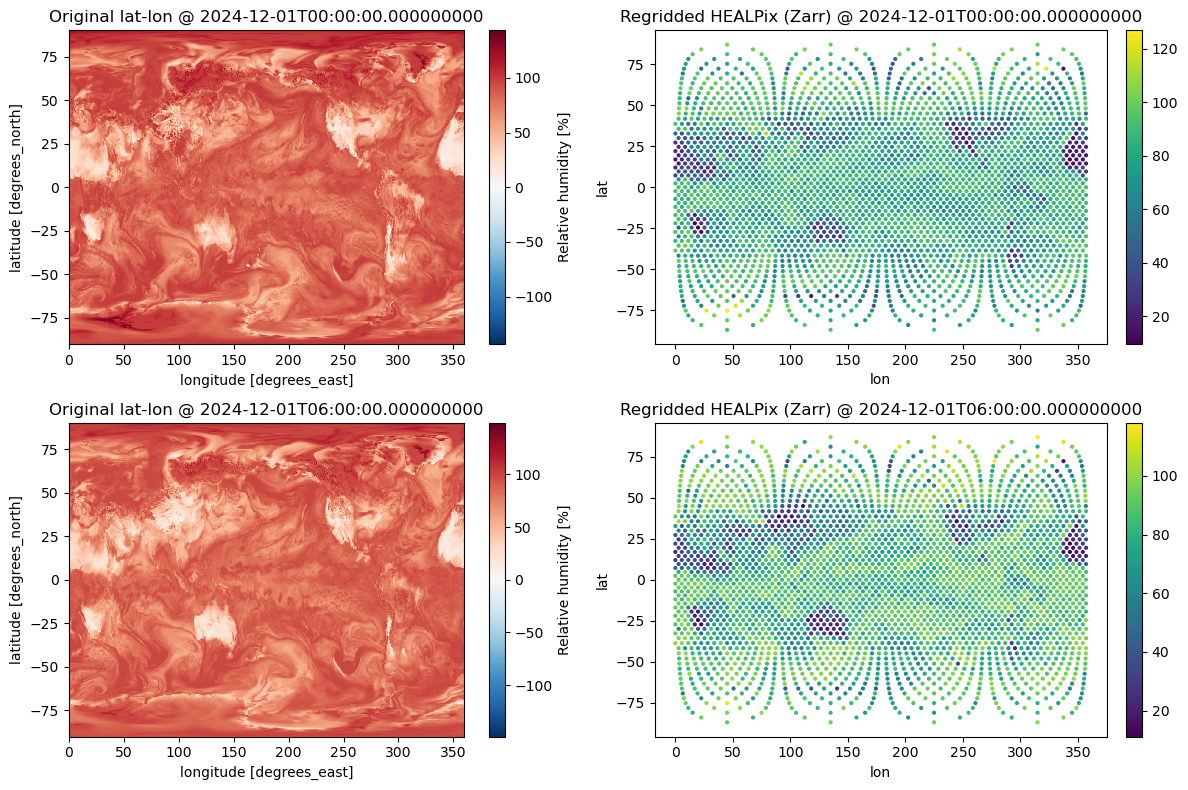

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy_healpix import HEALPix
import xarray as xr

# ======================================================
# SECTION 5: 2 time samples from Zarr + plots (original + regridded)
# ======================================================

# 1) Open Zarr
z = xr.open_zarr(ZARR_PATH)
print("Zarr vars:", list(z.data_vars))

# 2) Pick HEALPix variable from Zarr (prefer hp16)
hp_var_candidates = [v for v in z.data_vars if "hp16" in v.lower()]
if not hp_var_candidates:
    # fallback: pick first var
    hp_var = list(z.data_vars)[0]
else:
    hp_var = hp_var_candidates[0]

hp = z[hp_var]
print("Using HEALPix var:", hp_var)
print("HEALPix dims:", hp.dims)

# 3) Detect dims robustly
t_dim = next((d for d in hp.dims if "time" in d.lower()), hp.dims[0])
l_dim = next((d for d in hp.dims if "level" in d.lower()), None)
p_dim = next((d for d in hp.dims if "pix" in d.lower() or d.lower() in ["ipix", "pixel"]), hp.dims[-1])

times = hp[t_dim].values
if len(times) < 2:
    raise ValueError("Zarr store has <2 time samples. Run pipeline for more times/days first.")

# 4) Choose two different indices (avoids duplicates / nearest issues)
iA = 0
iB = 1
while iB < len(times) and times[iB] == times[iA]:
    iB += 1
if iB >= len(times):
    raise ValueError("All time values in Zarr are identical. Fix time coordinate when writing day_hp to Zarr.")

print("Chosen indices:", iA, iB)
print("Chosen times:", times[iA], times[iB])

# 5) Prepare lon/lat centers for HEALPix pixels (for MAP-like plot)
npix = hp.sizes[p_dim]
nside = int(round(np.sqrt(npix / 12)))
hp_grid = HEALPix(nside=nside, order="ring", frame=None)
ipix = np.arange(npix)
lon, lat = hp_grid.healpix_to_lonlat(ipix)
lon_deg = lon.to_value(u.deg)
lat_deg = lat.to_value(u.deg)

# 6) Helper: plot original lat-lon for the same time
def plot_original_latlon(t, ax, title):
    # If you already have `da` loaded in the notebook, try to use it
    if "da" in globals():
        da0 = da
        t0 = next((d for d in da0.dims if "time" in d.lower()), None)
        if t0 is not None:
            try:
                da_ll = da0.sel({t0: t}, method="nearest")
                l0 = next((d for d in da_ll.dims if "level" in d.lower()), None)
                if l0 is not None:
                    da_ll = da_ll.isel({l0: 0})
                da_ll.plot(ax=ax)
                ax.set_title(title)
                return
            except Exception:
                pass

    # Fallback: try to open matching daily NetCDF from archive/raw by date string
    day_str = np.datetime_as_string(np.datetime64(t, "D"))  # 'YYYY-MM-DD'
    candidates = sorted(list(PATHS["archive"].glob(f"*{day_str}*"))) + sorted(list(PATHS["raw"].glob(f"*{day_str}*")))
    if not candidates:
        ax.set_title(title + " (original not found)")
        ax.text(0.5, 0.5, f"No NetCDF for {day_str} in archive/raw", ha="center", va="center", transform=ax.transAxes)
        return

    nc_path = candidates[0]
    ds = xr.open_dataset(nc_path, engine="h5netcdf")

    # pick a reasonable variable
    if "da" in globals() and da.name in ds.data_vars:
        orig_var = da.name
    else:
        orig_var = list(ds.data_vars)[0]

    da0 = ds[orig_var]
    tt = next((d for d in da0.dims if "time" in d.lower()), da0.dims[0])
    da_ll = da0.sel({tt: t}, method="nearest")
    ll = next((d for d in da_ll.dims if "level" in d.lower()), None)
    if ll is not None:
        da_ll = da_ll.isel({ll: 0})

    da_ll.plot(ax=ax)
    ax.set_title(title + f" ({orig_var})")

# 7) Helper: plot HEALPix map from Zarr slice
def plot_healpix_map(hp_slice, ax, title):
    sc = ax.scatter(lon_deg, lat_deg, c=hp_slice.values, s=4)
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")

# 8) Build slices A and B FROM ZARR (strict isel to guarantee different samples)
iselA = {t_dim: iA}
iselB = {t_dim: iB}
if l_dim is not None:
    iselA[l_dim] = 0
    iselB[l_dim] = 0

hpA = hp.isel(**iselA)
hpB = hp.isel(**iselB)

# 9) Plot 2x2: (original A, healpix A, original B, healpix B)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plot_original_latlon(times[iA], axs[0, 0], f"Original lat-lon @ {times[iA]}")
plot_healpix_map(hpA, axs[0, 1], f"Regridded HEALPix (Zarr) @ {times[iA]}")

plot_original_latlon(times[iB], axs[1, 0], f"Original lat-lon @ {times[iB]}")
plot_healpix_map(hpB, axs[1, 1], f"Regridded HEALPix (Zarr) @ {times[iB]}")

plt.tight_layout()
plt.show()
